## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
video-games-sales-2019.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 390 kB/s 


In [ ]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

## カテゴリデータのエンコーディング

In [ ]:
df_number = df.select_dtypes(include="number")
df_category = df.select_dtypes(include="object")

display(pd.DataFrame(df_category.isnull().sum()).T)
display(df_category.head(1))

pd.DataFrame(df_category.nunique(), columns=["ユニーク数"])

,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,Last_Update,url,img_url
0,0,0,0,32169,0,0,17,46606,0,0


,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,Last_Update,url,img_url
0,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,/games/boxart/full_2258645AmericaFrontccc.jpg


,ユニーク数
Name,37102
basename,36672
Genre,20
ESRB_Rating,8
Platform,74
Publisher,3069
Developer,8064
Last_Update,430
url,55791
img_url,47601


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

### 全てOrdinalEncoding

In [ ]:
# 数値データとカテゴリーデータに分ける
X_train_number = X_train.select_dtypes(include="number")
X_test_number = X_test.select_dtypes(include="number")

X_train_category = X_train.select_dtypes(include="object")
X_test_category = X_test.select_dtypes(include="object")

# index をリセット
X_train_number = X_train_number.reset_index(drop=True)
X_test_number = X_test_number.reset_index(drop=True)

X_train_category = X_train_category.reset_index(drop=True)
X_test_category = X_test_category.reset_index(drop=True)

In [ ]:
# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in X_train_category.columns:
    ordinal_one_cols_mapping = []
    for category in natsorted(X_train_category[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)

In [ ]:
# エンコーディング設定
ode = OrdinalEncoder(
    handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
    unknown_value = -2,
    dtype = np.float64,
    categories = ordinal_all_cols_mapping
)

# OrdinalEncoderは欠損値があっても処理できるが、エンコーディングしないので欠損値を missing に置き換える
X_train_category = X_train_category.fillna("missing")
X_test_category = X_test_category.fillna("missing")

# エンコーディング
# trainデータは学習と変換、testデータは変換のみを実施。trainの学習パターン通りに変換するため
X_train_labels = ode.fit_transform(X_train_category)
X_test_labels = ode.transform(X_test_category)

# OrdinalEncoder は np.array型に変換してしまうため、DataFrame型で再構築する
X_train_oe = pd.DataFrame(
    X_train_labels,
    columns=X_train_category.columns
)

X_test_oe = pd.DataFrame(
    X_test_labels,
    columns=X_test_category.columns
)

# 数値データを結合
X_train_oe = pd.concat([X_train_oe, X_train_number ], axis=1)
X_test_oe = pd.concat([X_test_oe, X_test_number ], axis=1)

# 正規化
sc = StandardScaler()

X_train_oe = pd.DataFrame(
                            sc.fit_transform(X_train_oe),
                            columns=X_train_oe.columns
                            )

X_test_oe = pd.DataFrame(
                            sc.transform(X_test_oe),
                            columns=X_test_oe.columns
                            )

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135113	Test's rmse: 0.235156


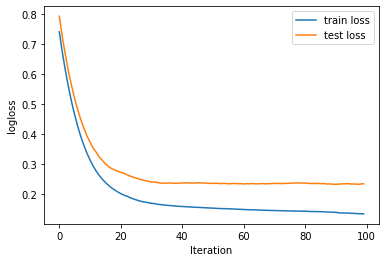

RMSE: 0.2351561219774193


In [ ]:
# 以下、学習、推論
lgb_train = lgb.Dataset(X_train_oe, y_train)
lgb_test = lgb.Dataset(X_test_oe, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},  # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_oe)

# 精度評価
rmse_ode = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_ode)

## ユニーク数が少ない項目はOneHotEncoding、多い項目はOrdinalEncoding

In [ ]:
# 数値データとカテゴリーデータに分ける
X_train_number = X_train.select_dtypes(include="number")
X_test_number = X_test.select_dtypes(include="number")

X_train_category = X_train.select_dtypes(include="object")
X_test_category = X_test.select_dtypes(include="object")

# index をリセット
X_train_number = X_train_number.reset_index(drop=True)
X_test_number = X_test_number.reset_index(drop=True)

X_train_category = X_train_category.reset_index(drop=True)
X_test_category = X_test_category.reset_index(drop=True)

# OneHotEncoderは欠損値があっても処理できるが、エンコーディングしないので欠損値を missing に置き換える
X_train_category = X_train_category.fillna("missing")
X_test_category = X_test_category.fillna("missing")

# ユニーク数に応じてカラムを分割する
category_unique_num = df.drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="object").nunique()
few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index

In [ ]:
# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_en = []

for column in many_kinds_category_columns:
    ordinal_one_cols_mapping = []
    for category in natsorted(X_train_category[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping_en.append(ordinal_one_cols_mapping)

In [ ]:
# エンコーディング設定
ode = OrdinalEncoder(
    handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
    unknown_value = -1, # -2,
    dtype = np.float64,
    categories = ordinal_all_cols_mapping_en
)

ohe = OneHotEncoder(
    handle_unknown = 'ignore',
    sparse = False,
    dtype = np.int64,
    )

# エンコーディング
# trainデータは学習と変換、testデータは変換のみを実施。trainの学習パターン通りに変換するため

# OneHotEncoder
X_train_ohe_labels = ohe.fit_transform(X_train_category[few_kinds_category_columns])
X_test_ohe_labels = ohe.transform(X_test_category[few_kinds_category_columns ])

# OrdinalEncoder
X_train_ode_labels = ode.fit_transform(X_train_category[many_kinds_category_columns]) + 1
X_test_ode_labels = ode.transform(X_test_category[many_kinds_category_columns ]) + 1

# np.array型になってしまうため、DataFrame型で再構築する
# trainデータ
X_train_ode = pd.DataFrame(
    X_train_ode_labels,
    columns=X_train_category[many_kinds_category_columns].columns
)
X_train_ohe = pd.DataFrame(
    X_train_ohe_labels,
    columns=ohe.get_feature_names_out(few_kinds_category_columns)
)
X_train_en = pd.concat([X_train_ohe, X_train_ode], axis=1)

# testデータ
X_test_ode = pd.DataFrame(
    X_test_ode_labels,
    columns=X_test_category[many_kinds_category_columns].columns
)
X_test_ohe = pd.DataFrame(
    X_test_ohe_labels,
    columns=ohe.get_feature_names_out(few_kinds_category_columns)
)
X_test_en = pd.concat([X_test_ohe, X_test_ode], axis=1)


# 数値データを結合
X_train_en = pd.concat([X_train_en, X_train_number ], axis=1)
X_test_en = pd.concat([X_test_en, X_test_number ], axis=1)

# 正規化
sc = StandardScaler()
X_train_en = pd.DataFrame(
                            sc.fit_transform(X_train_en),
                            columns=X_train_en.columns
                            )

X_test_en = pd.DataFrame(
                            sc.transform(X_test_en),
                            columns=X_test_en.columns
                            )

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130501	Test's rmse: 0.228831


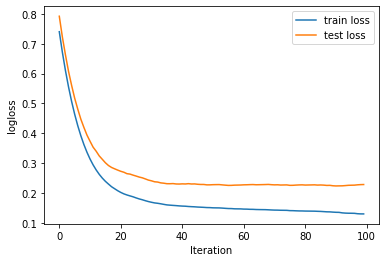

RMSE: 0.22883073440896592


In [ ]:
# 以下、学習、推論
lgb_train = lgb.Dataset(X_train_en, y_train)
lgb_test = lgb.Dataset(X_test_en, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': {'rmse'},  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_en)

# 精度評価
rmse_en = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_en)

## Category_Encoders を使う

In [ ]:
# ユニーク数に応じてカラムを分割する
category_unique_num = df.drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1).select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index

In [ ]:
# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)

In [ ]:
# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データを壊さないようにコピーする
X_train_ce = X_train.copy()
X_test_ce = X_test.copy()

# 欠損値処理
category_columns = category_unique_num.index

X_train_ce[category_columns] = X_train_ce[category_columns].fillna("missing")
X_test_ce[category_columns] = X_test_ce[category_columns].fillna("missing")

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134021	Test's rmse: 0.226488


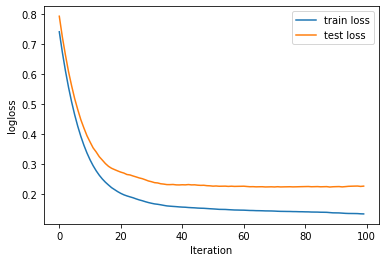

RMSE: 0.22648763368118405


In [ ]:
# 以下、学習、推論
lgb_train = lgb.Dataset(X_train_ce, y_train)
lgb_test = lgb.Dataset(X_test_ce, y_test, reference=lgb_train)

params = {
          'task': 'train',                      # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰分類を指定
          'metric': {'rmse'},               # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )  

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()


# 推論
y_pred = model.predict(X_test_ce)

# 精度評価
rmse_ce = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_ce)

In [ ]:
print("OrdinalEncodingのみ:", rmse_ode)
print("sklearn で OneHot+Ordinal Encoding:", rmse_en)
print("Category Encorders で OneHot+Ordinal Encoding:", rmse_ce)

OrdinalEncodingのみ: 0.2351561219774193
sklearn で OneHot+Ordinal Encoding: 0.22883073440896592
Category Encorders で OneHot+Ordinal Encoding: 0.22648763368118405


## Sklearn と Category_Encodings の処理結果をカラムごとに比較

In [ ]:
for column_en, column_ce in zip(natsorted(X_train_en.columns), natsorted(X_train_ce.columns)):
    print(
        column_en,
        "min:", X_train_en[column_en].unique().min(), 
        "max:", X_train_en[column_en].unique().max(), 
        "length:", len(X_train_en[column_en].unique())
    )
    display(X_train_en.groupby(column_en).count().iloc[:, :1].T)

    print(
        column_ce,
        "min:", X_train_ce[column_ce].unique().min(), 
        "max:", X_train_ce[column_ce].unique().max(), 
        "length:", len(X_train_ce[column_ce].unique())
    )
    display(X_train_ce.groupby(column_ce).count().iloc[:, :1].T)
    print()

Critic_Score min: nan max: nan length: 83


Critic_Score,-4.290447,-4.081345,-4.011644,-3.941943,-3.802542,-3.663141,-3.593440,-3.384338,-3.314638,-3.244937,-3.175236,-3.035835,-2.966134,-2.896434,-2.826733,-2.757032,-2.687332,-2.547930,-2.478230,-2.408529,-2.338828,-2.269128,-2.199427,-2.129727,-2.060026,-1.990325,-1.920625,-1.850924,-1.781223,-1.711523,-1.641822,-1.572121,-1.502421,-1.432720,-1.363019,-1.293319,-1.223618,-1.153917,-1.084217,-1.014516,...,-0.805414,-0.735714,-0.666013,-0.596312,-0.526612,-0.456911,-0.387210,-0.317510,-0.247809,-0.178108,-0.108408,-0.038707,0.030994,0.100694,0.170395,0.240096,0.309796,0.379497,0.449197,0.518898,0.588599,0.658299,0.728000,0.797701,0.867401,0.937102,1.006803,1.076503,1.146204,1.215905,1.285605,1.355306,1.425007,1.494707,1.564408,1.634109,1.703809,1.773510,1.843210,1.982612
ESRB_Rating_E,2,1,1,2,1,1,6,1,2,5,2,1,3,8,6,4,5,14,4,6,16,3,25,3,10,14,11,15,12,11,23,21,45,16,30,21,17,34,29,20,...,88,31,47,57,50,77,58,55,70,60,153,52,63,82,88,111,69,74,68,95,148,87,93,93,70,87,66,59,59,39,72,43,31,26,16,20,7,4,2,3


Critic_Score min: nan max: nan length: 83


Critic_Score,-4.290447,-4.081345,-4.011644,-3.941943,-3.802542,-3.663141,-3.593440,-3.384338,-3.314638,-3.244937,-3.175236,-3.035835,-2.966134,-2.896434,-2.826733,-2.757032,-2.687332,-2.547930,-2.478230,-2.408529,-2.338828,-2.269128,-2.199427,-2.129727,-2.060026,-1.990325,-1.920625,-1.850924,-1.781223,-1.711523,-1.641822,-1.572121,-1.502421,-1.432720,-1.363019,-1.293319,-1.223618,-1.153917,-1.084217,-1.014516,...,-0.805414,-0.735714,-0.666013,-0.596312,-0.526612,-0.456911,-0.387210,-0.317510,-0.247809,-0.178108,-0.108408,-0.038707,0.030994,0.100694,0.170395,0.240096,0.309796,0.379497,0.449197,0.518898,0.588599,0.658299,0.728000,0.797701,0.867401,0.937102,1.006803,1.076503,1.146204,1.215905,1.285605,1.355306,1.425007,1.494707,1.564408,1.634109,1.703809,1.773510,1.843210,1.982612
Rank,2,1,1,2,1,1,6,1,2,5,2,1,3,8,6,4,5,14,4,6,16,3,25,3,10,14,11,15,12,11,23,21,45,16,30,21,17,34,29,20,...,88,31,47,57,50,77,58,55,70,60,153,52,63,82,88,111,69,74,68,95,148,87,93,93,70,87,66,59,59,39,72,43,31,26,16,20,7,4,2,3



Developer min: -1.7351311992952159 max: 1.6775196802133707 length: 2455


Developer,-1.735131,-1.733741,-1.732350,-1.730959,-1.729569,-1.728178,-1.726787,-1.725397,-1.724006,-1.722615,-1.721225,-1.719834,-1.718443,-1.717053,-1.715662,-1.714271,-1.712881,-1.711490,-1.710100,-1.708709,-1.707318,-1.705928,-1.704537,-1.703146,-1.701756,-1.700365,-1.698974,-1.697584,-1.696193,-1.694802,-1.693412,-1.692021,-1.690630,-1.689240,-1.687849,-1.686459,-1.685068,-1.683677,-1.682287,-1.680896,...,1.623284,1.624675,1.626066,1.627456,1.628847,1.630238,1.631628,1.633019,1.634410,1.635800,1.637191,1.638582,1.639972,1.641363,1.642753,1.644144,1.645535,1.646925,1.648316,1.649707,1.651097,1.652488,1.653879,1.655269,1.656660,1.658051,1.659441,1.660832,1.662223,1.663613,1.665004,1.666394,1.667785,1.669176,1.670566,1.671957,1.673348,1.674738,1.676129,1.677520
ESRB_Rating_E,1,2,1,1,2,2,12,1,1,1,2,3,1,2,1,7,1,2,2,2,2,23,1,2,2,7,5,1,9,16,18,11,1,2,2,5,1,1,2,1,...,2,1,4,1,2,2,1,2,1,1,1,2,1,1,1,1,2,1,1,1,8,1,2,9,1,13,1,2,3,30,1,1,1,2,4,6,1,1,13,2


Developer min: -1.7371251052310395 max: 1.6768565504042434 length: 2455


Developer,-1.737125,-1.734344,-1.732953,-1.731563,-1.730172,-1.728781,-1.727391,-1.726000,-1.724609,-1.723219,-1.721828,-1.720438,-1.719047,-1.717656,-1.716266,-1.714875,-1.713484,-1.712094,-1.710703,-1.709313,-1.707922,-1.706531,-1.705141,-1.703750,-1.702360,-1.700969,-1.699578,-1.698188,-1.696797,-1.695406,-1.694016,-1.692625,-1.691235,-1.689844,-1.688453,-1.687063,-1.685672,-1.684281,-1.682891,-1.681500,...,1.622622,1.624013,1.625403,1.626794,1.628185,1.629575,1.630966,1.632357,1.633747,1.635138,1.636528,1.637919,1.639310,1.640700,1.642091,1.643482,1.644872,1.646263,1.647653,1.649044,1.650435,1.651825,1.653216,1.654607,1.655997,1.657388,1.658778,1.660169,1.661560,1.662950,1.664341,1.665732,1.667122,1.668513,1.669903,1.671294,1.672685,1.674075,1.675466,1.676857
Rank,3,1,2,1,1,2,2,12,1,1,1,2,3,1,2,1,7,1,2,2,2,2,23,1,2,2,7,5,1,9,16,18,11,1,2,2,5,1,1,2,...,2,2,1,4,1,2,2,1,2,1,1,1,2,1,1,1,1,2,1,1,1,8,1,2,9,1,13,1,2,30,1,1,1,2,4,6,1,1,13,2



ESRB_Rating_E min: -0.658096341011341 max: 1.519534356418443 length: 2


ESRB_Rating_E,-0.658096,1.519534
ESRB_Rating_E10,9483,4107


ESRB_Rating_E min: -0.658096341011341 max: 1.519534356418443 length: 2


ESRB_Rating_E,-0.658096,1.519534
Rank,9483,4107



ESRB_Rating_E10 min: -0.3224600807163029 max: 3.101159057513819 length: 2


ESRB_Rating_E10,-0.322460,3.101159
ESRB_Rating_E,12310,1280


ESRB_Rating_E10 min: -0.3224600807163029 max: 3.101159057513819 length: 2


ESRB_Rating_E10,-0.322460,3.101159
Rank,12310,1280



ESRB_Rating_EC min: -0.03839061540937688 max: 26.048032555262218 length: 2


ESRB_Rating_EC,-0.038391,26.048033
ESRB_Rating_E,13570,20


ESRB_Rating_EC min: -0.03839061540937688 max: 26.048032555262218 length: 2


ESRB_Rating_EC,-0.038391,26.048033
Rank,13570,20



ESRB_Rating_M min: -0.34773148986900704 max: 2.8757821167611466 length: 2


ESRB_Rating_M,-0.347731,2.875782
ESRB_Rating_E,12124,1466


ESRB_Rating_M min: -0.34773148986900704 max: 2.8757821167611466 length: 2


ESRB_Rating_M,-0.347731,2.875782
Rank,12124,1466



ESRB_Rating_RP min: -0.04543778431032922 max: 22.008115386310177 length: 2


ESRB_Rating_RP,-0.045438,22.008115
ESRB_Rating_E,13562,28


ESRB_Rating_RP min: -0.04543778431032922 max: 22.008115386310177 length: 2


ESRB_Rating_RP,-0.045438,22.008115
Rank,13562,28



ESRB_Rating_T min: -0.5068892748509625 max: 1.9728174368929465 length: 2


ESRB_Rating_T,-0.506889,1.972817
ESRB_Rating_E,10812,2778


ESRB_Rating_T min: -0.5068892748509625 max: 1.9728174368929465 length: 2


ESRB_Rating_T,-0.506889,1.972817
Rank,10812,2778



ESRB_Rating_missing min: -0.6356655319092623 max: 1.5731543552415623 length: 2


ESRB_Rating_missing,-0.635666,1.573154
ESRB_Rating_E,9679,3911


ESRB_Rating_missing min: -0.6356655319092623 max: 1.5731543552415623 length: 2


ESRB_Rating_missing,-0.635666,1.573154
Rank,9679,3911



Genre min: -1.5100858953297744 max: 1.514372917232093 length: 20


Genre,-1.510086,-1.350904,-1.191722,-1.032540,-0.873358,-0.714176,-0.554994,-0.395812,-0.236630,-0.077448,0.081735,0.240917,0.400099,0.559281,0.718463,0.877645,1.036827,1.196009,1.355191,1.514373
ESRB_Rating_E,2047,178,1347,1,1,634,21,1608,91,20,661,521,989,1113,1,1064,795,1829,593,76


Genre min: -1.5100858953297744 max: 1.514372917232093 length: 20


Genre,-1.510086,-1.350904,-1.191722,-1.032540,-0.873358,-0.714176,-0.554994,-0.395812,-0.236630,-0.077448,0.081735,0.240917,0.400099,0.559281,0.718463,0.877645,1.036827,1.196009,1.355191,1.514373
Rank,2047,178,1347,1,1,634,21,1608,91,20,661,521,989,1113,1,1064,795,1829,593,76



Last_Update min: -3.6529481231856957 max: 0.4188343036068043 length: 332


Last_Update,-3.652948,-3.640647,-3.628345,-3.616044,-3.603742,-3.591441,-3.579139,-3.566838,-3.554536,-3.542235,-3.529934,-3.517632,-3.505331,-3.493029,-3.480728,-3.468426,-3.456125,-3.443823,-3.431522,-3.419220,-3.406919,-3.394618,-3.382316,-3.370015,-3.357713,-3.345412,-3.333110,-3.320809,-3.308507,-3.296206,-3.283904,-3.271603,-3.259301,-3.247000,-3.234699,-3.222397,-3.210096,-3.197794,-3.185493,-3.173191,...,-0.060923,-0.048621,-0.036320,-0.024018,-0.011717,0.000585,0.012886,0.025188,0.037489,0.049791,0.062092,0.074393,0.086695,0.098996,0.111298,0.123599,0.135901,0.148202,0.160504,0.172805,0.185107,0.197408,0.209710,0.222011,0.234312,0.246614,0.258915,0.271217,0.283518,0.295820,0.308121,0.320423,0.332724,0.345026,0.357327,0.369628,0.381930,0.394231,0.406533,0.418834
ESRB_Rating_E,20,1,12,18,3,11,2,3,2,11,2,2,20,4,6,13,3,9,23,4,5,3,12,1,17,1,16,25,7,17,28,24,9,3,1,17,11,14,11,1,...,5,8,1,5,1,5,10,8,6,2,6,1,2,21,1,3,25,5,3,9,6,8,4,2,21,18,7,4,17,1,3,11,8,6,8,17,3,10,8,10929


Last_Update min: -0.40790671051300853 max: 3.9388001909539794 length: 332


Last_Update,-0.407907,-0.381722,-0.368629,-0.355537,-0.342444,-0.329352,-0.316259,-0.303167,-0.290074,-0.276982,-0.263889,-0.250797,-0.237704,-0.224612,-0.211519,-0.198427,-0.185334,-0.172242,-0.159149,-0.146057,-0.132964,-0.119872,-0.106779,-0.093687,-0.080594,-0.067502,-0.054409,-0.041317,-0.028224,-0.015132,-0.002039,0.011053,0.024145,0.037238,0.050330,0.063423,0.076515,0.089608,0.102700,0.115793,...,3.428193,3.441286,3.454378,3.467471,3.480563,3.493656,3.506748,3.519840,3.532933,3.546025,3.559118,3.572210,3.585303,3.598395,3.611488,3.624580,3.637673,3.650765,3.663858,3.676950,3.690043,3.703135,3.716228,3.729320,3.742413,3.755505,3.768598,3.781690,3.794783,3.807875,3.820968,3.834060,3.847153,3.860245,3.873338,3.886430,3.899523,3.912615,3.925708,3.938800
Rank,10929,20,1,12,18,3,11,2,3,2,11,2,2,20,4,6,13,3,9,23,4,5,3,12,1,17,1,16,25,7,17,28,24,9,3,1,17,11,14,11,...,5,5,8,1,5,1,5,10,8,6,2,6,1,2,21,1,3,25,5,3,9,6,8,4,2,21,18,7,4,17,1,3,11,8,6,8,17,3,10,8



Name min: -1.7405271470866597 max: 1.7173294738846578 length: 10180


Name,-1.740527,-1.740187,-1.739848,-1.739508,-1.739168,-1.738829,-1.738489,-1.738149,-1.737810,-1.737470,-1.737130,-1.736790,-1.736451,-1.736111,-1.735771,-1.735432,-1.735092,-1.734752,-1.734412,-1.734073,-1.733733,-1.733393,-1.733054,-1.732714,-1.732374,-1.732035,-1.731695,-1.731355,-1.731015,-1.730676,-1.730336,-1.729996,-1.729657,-1.729317,-1.728977,-1.728637,-1.728298,-1.727958,-1.727618,-1.727279,...,1.704081,1.704421,1.704760,1.705100,1.705440,1.705780,1.706119,1.706459,1.706799,1.707138,1.707478,1.707818,1.708157,1.708497,1.708837,1.709177,1.709516,1.709856,1.710196,1.710535,1.710875,1.711215,1.711554,1.711894,1.712234,1.712574,1.712913,1.713253,1.713593,1.713932,1.714272,1.714612,1.714952,1.715291,1.715631,1.715971,1.716310,1.716650,1.716990,1.717329
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,2,2,1,1,2,1,1,2,2,1,3,1,1,5,1,1,1,1,1,2,1,...,1,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,2,1,3,1,1,1,1,1,1,1,1,2


Name min: -1.7405271470866597 max: 1.7173294738846578 length: 10180


Name,-1.740527,-1.740187,-1.739848,-1.739508,-1.739168,-1.738829,-1.738489,-1.738149,-1.737810,-1.737470,-1.737130,-1.736790,-1.736451,-1.736111,-1.735771,-1.735432,-1.735092,-1.734752,-1.734412,-1.734073,-1.733733,-1.733393,-1.733054,-1.732714,-1.732374,-1.732035,-1.731695,-1.731355,-1.731015,-1.730676,-1.730336,-1.729996,-1.729657,-1.729317,-1.728977,-1.728637,-1.728298,-1.727958,-1.727618,-1.727279,...,1.704081,1.704421,1.704760,1.705100,1.705440,1.705780,1.706119,1.706459,1.706799,1.707138,1.707478,1.707818,1.708157,1.708497,1.708837,1.709177,1.709516,1.709856,1.710196,1.710535,1.710875,1.711215,1.711554,1.711894,1.712234,1.712574,1.712913,1.713253,1.713593,1.713932,1.714272,1.714612,1.714952,1.715291,1.715631,1.715971,1.716310,1.716650,1.716990,1.717329
Rank,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,2,2,1,1,2,1,1,2,2,1,3,1,1,5,1,1,1,1,1,2,1,...,1,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,3,1,1,1,1,1,2,1,3,1,1,1,1,1,1,1,1,2



Platform min: -1.8602336750779578 max: 1.6587516304004004 length: 39


Platform,-1.860234,-1.767629,-1.675024,-1.582419,-1.489814,-1.397209,-1.304604,-1.212000,-1.119395,-1.026790,-0.934185,-0.841580,-0.748975,-0.656370,-0.563765,-0.471161,-0.378556,-0.285951,-0.193346,-0.100741,-0.008136,0.084469,0.177074,0.269678,0.362283,0.454888,0.547493,0.640098,0.732703,0.825308,0.917913,1.010517,1.103122,1.195727,1.288332,1.380937,1.473542,1.566147,1.658752
ESRB_Rating_E,4,419,90,35,1698,40,666,2,361,18,1,3,198,35,7,193,1,1137,2,1,835,1528,969,668,13,974,469,119,4,128,3,6,2,994,101,899,586,7,374


Platform min: -1.8602336750779578 max: 1.6587516304004004 length: 39


Platform,-1.860234,-1.767629,-1.675024,-1.582419,-1.489814,-1.397209,-1.304604,-1.212000,-1.119395,-1.026790,-0.934185,-0.841580,-0.748975,-0.656370,-0.563765,-0.471161,-0.378556,-0.285951,-0.193346,-0.100741,-0.008136,0.084469,0.177074,0.269678,0.362283,0.454888,0.547493,0.640098,0.732703,0.825308,0.917913,1.010517,1.103122,1.195727,1.288332,1.380937,1.473542,1.566147,1.658752
Rank,4,419,90,35,1698,40,666,2,361,18,1,3,198,35,7,193,1,1137,2,1,835,1528,969,668,13,974,469,119,4,128,3,6,2,994,101,899,586,7,374



Publisher min: -1.540335729215839 max: 1.7427261098477214 length: 648


Publisher,-1.540336,-1.535261,-1.530187,-1.525113,-1.520039,-1.514964,-1.509890,-1.504816,-1.499741,-1.494667,-1.489593,-1.484519,-1.479444,-1.474370,-1.469296,-1.464221,-1.459147,-1.454073,-1.448999,-1.443924,-1.438850,-1.433776,-1.428701,-1.423627,-1.418553,-1.413479,-1.408404,-1.403330,-1.398256,-1.393181,-1.388107,-1.383033,-1.377959,-1.372884,-1.367810,-1.362736,-1.357662,-1.352587,-1.347513,-1.342439,...,1.544829,1.549903,1.554978,1.560052,1.565126,1.570200,1.575275,1.580349,1.585423,1.590498,1.595572,1.600646,1.605720,1.610795,1.615869,1.620943,1.626018,1.631092,1.636166,1.641240,1.646315,1.651389,1.656463,1.661538,1.666612,1.671686,1.676760,1.681835,1.686909,1.691983,1.697058,1.702132,1.707206,1.712280,1.717355,1.722429,1.727503,1.732578,1.737652,1.742726
ESRB_Rating_E,4,83,24,119,1,30,1,65,4,3,2,1,4,1,92,4,1,14,2,3,1,1,4,20,8,1,3,135,6,14,739,2,1,1,5,1,43,84,3,32,...,10,2,2,1,1,8,28,1,2,90,115,1,3,1,1,8,1,8,18,2,62,4,12,5,1,2,14,45,5,1,1,3,4,4,1,1,3,1,2,2


Publisher min: -1.540335729215839 max: 1.7427261098477214 length: 648


Publisher,-1.540336,-1.535261,-1.530187,-1.525113,-1.520039,-1.514964,-1.509890,-1.504816,-1.499741,-1.494667,-1.489593,-1.484519,-1.479444,-1.474370,-1.469296,-1.464221,-1.459147,-1.454073,-1.448999,-1.443924,-1.438850,-1.433776,-1.428701,-1.423627,-1.418553,-1.413479,-1.408404,-1.403330,-1.398256,-1.393181,-1.388107,-1.383033,-1.377959,-1.372884,-1.367810,-1.362736,-1.357662,-1.352587,-1.347513,-1.342439,...,1.544829,1.549903,1.554978,1.560052,1.565126,1.570200,1.575275,1.580349,1.585423,1.590498,1.595572,1.600646,1.605720,1.610795,1.615869,1.620943,1.626018,1.631092,1.636166,1.641240,1.646315,1.651389,1.656463,1.661538,1.666612,1.671686,1.676760,1.681835,1.686909,1.691983,1.697058,1.702132,1.707206,1.712280,1.717355,1.722429,1.727503,1.732578,1.737652,1.742726
Rank,4,83,24,119,1,30,1,65,4,3,2,1,4,1,92,4,1,14,2,3,1,1,4,20,8,1,3,135,6,14,739,2,1,1,5,1,43,84,3,32,...,10,2,2,1,1,8,28,1,2,90,115,1,3,1,1,8,1,8,18,2,62,4,12,5,1,2,14,45,5,1,1,3,4,4,1,1,3,1,2,2



Rank min: -1.8422789359904337 max: 1.66987675503905 length: 13590


Rank,-1.842279,-1.840624,-1.839962,-1.838141,-1.837810,-1.837479,-1.837314,-1.837148,-1.836817,-1.834335,-1.833507,-1.832680,-1.832183,-1.832018,-1.831852,-1.831190,-1.830859,-1.830032,-1.829535,-1.828377,-1.827880,-1.826060,-1.825067,-1.824405,-1.824074,-1.823412,-1.822749,-1.822584,-1.822253,-1.821260,-1.821094,-1.820598,-1.820432,-1.820267,-1.819936,-1.819439,-1.818943,-1.818115,-1.817950,-1.817453,...,1.660609,1.660774,1.660940,1.661105,1.661271,1.662098,1.662264,1.662429,1.662595,1.662760,1.662926,1.663091,1.663257,1.663422,1.663588,1.663753,1.663919,1.664084,1.664250,1.664415,1.664912,1.665077,1.665574,1.665739,1.666070,1.666236,1.666401,1.666567,1.666732,1.666898,1.667063,1.667229,1.667394,1.667560,1.667725,1.668056,1.668718,1.669049,1.669546,1.669877
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Rank min: -1.8422789359904337 max: 1.66987675503905 length: 13590


Rank,-1.842279,-1.840624,-1.839962,-1.838141,-1.837810,-1.837479,-1.837314,-1.837148,-1.836817,-1.834335,-1.833507,-1.832680,-1.832183,-1.832018,-1.831852,-1.831190,-1.830859,-1.830032,-1.829535,-1.828377,-1.827880,-1.826060,-1.825067,-1.824405,-1.824074,-1.823412,-1.822749,-1.822584,-1.822253,-1.821260,-1.821094,-1.820598,-1.820432,-1.820267,-1.819936,-1.819439,-1.818943,-1.818115,-1.817950,-1.817453,...,1.660609,1.660774,1.660940,1.661105,1.661271,1.662098,1.662264,1.662429,1.662595,1.662760,1.662926,1.663091,1.663257,1.663422,1.663588,1.663753,1.663919,1.664084,1.664250,1.664415,1.664912,1.665077,1.665574,1.665739,1.666070,1.666236,1.666401,1.666567,1.666732,1.666898,1.667063,1.667229,1.667394,1.667560,1.667725,1.668056,1.668718,1.669049,1.669546,1.669877
Name,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



Total_Shipped min: nan max: nan length: 1


Total_Shipped
ESRB_Rating_E


Total_Shipped min: nan max: nan length: 1


Total_Shipped
Rank



User_Score min: nan max: nan length: 38


User_Score,-4.697354,-4.316188,-3.325155,-1.876724,-1.648024,-1.419324,-1.343091,-1.266858,-1.038158,-0.961925,-0.885692,-0.809458,-0.733225,-0.656992,-0.580759,-0.504525,-0.428292,-0.275826,-0.199592,-0.123359,-0.047126,0.029107,0.105340,0.181574,0.257807,0.334040,0.410273,0.486507,0.562740,0.638973,0.715206,0.791440,0.867673,1.020139,1.096373,1.172606,1.248839
ESRB_Rating_E,1,1,1,1,3,1,1,2,1,1,4,1,3,1,1,3,3,2,2,9,2,3,2,4,8,2,2,3,4,12,9,3,4,3,5,1,1


User_Score min: nan max: nan length: 38


User_Score,-4.697354,-4.316188,-3.325155,-1.876724,-1.648024,-1.419324,-1.343091,-1.266858,-1.038158,-0.961925,-0.885692,-0.809458,-0.733225,-0.656992,-0.580759,-0.504525,-0.428292,-0.275826,-0.199592,-0.123359,-0.047126,0.029107,0.105340,0.181574,0.257807,0.334040,0.410273,0.486507,0.562740,0.638973,0.715206,0.791440,0.867673,1.020139,1.096373,1.172606,1.248839
Rank,1,1,1,1,3,1,1,2,1,1,4,1,3,1,1,3,3,2,2,9,2,3,2,4,8,2,2,3,4,12,9,3,4,3,5,1,1



VGChartz_Score min: nan max: nan length: 1


VGChartz_Score
ESRB_Rating_E


VGChartz_Score min: nan max: nan length: 1


VGChartz_Score
Rank



Vgchartzscore min: nan max: nan length: 53


Vgchartzscore,-3.255071,-3.110049,-2.892515,-2.747493,-2.529960,-2.384937,-2.312426,-2.167404,-2.094893,-2.022381,-1.877359,-1.804848,-1.659826,-1.587315,-1.514803,-1.442292,-1.297270,-1.224759,-1.152248,-1.079736,-1.007225,-0.934714,-0.789692,-0.717181,-0.572158,-0.499647,-0.427136,-0.354625,-0.282114,-0.209603,-0.137091,-0.064580,0.007931,0.080442,0.152953,0.225464,0.297976,0.370487,0.442998,0.515509,0.588020,0.660531,0.733042,0.805554,0.878065,0.950576,1.023087,1.095598,1.168109,1.240621,1.313132,1.458154
ESRB_Rating_E,3,2,2,1,6,2,1,1,1,1,1,3,1,2,1,1,1,1,2,17,2,4,1,7,4,8,4,27,1,9,5,3,15,3,6,14,6,28,6,13,12,8,13,10,6,11,4,17,8,4,8,3


Vgchartzscore min: nan max: nan length: 53


Vgchartzscore,-3.255071,-3.110049,-2.892515,-2.747493,-2.529960,-2.384937,-2.312426,-2.167404,-2.094893,-2.022381,-1.877359,-1.804848,-1.659826,-1.587315,-1.514803,-1.442292,-1.297270,-1.224759,-1.152248,-1.079736,-1.007225,-0.934714,-0.789692,-0.717181,-0.572158,-0.499647,-0.427136,-0.354625,-0.282114,-0.209603,-0.137091,-0.064580,0.007931,0.080442,0.152953,0.225464,0.297976,0.370487,0.442998,0.515509,0.588020,0.660531,0.733042,0.805554,0.878065,0.950576,1.023087,1.095598,1.168109,1.240621,1.313132,1.458154
Rank,3,2,2,1,6,2,1,1,1,1,1,3,1,2,1,1,1,1,2,17,2,4,1,7,4,8,4,27,1,9,5,3,15,3,6,14,6,28,6,13,12,8,13,10,6,11,4,17,8,4,8,3



Year min: nan max: nan length: 46


Year,-6.174758,-5.026604,-4.862582,-4.698560,-4.534538,-4.370515,-4.206493,-4.042471,-3.878449,-3.714427,-3.550405,-3.386383,-3.222361,-3.058339,-2.894317,-2.730295,-2.566273,-2.402250,-2.238228,-2.074206,-1.910184,-1.746162,-1.582140,-1.418118,-1.254096,-1.090074,-0.926052,-0.762030,-0.598008,-0.433985,-0.269963,-0.105941,0.058081,0.222103,0.386125,0.550147,0.714169,0.878191,1.042213,1.206235,1.370258,1.534280,1.698302,1.862324,2.026346
ESRB_Rating_E,5,1,5,1,3,5,32,27,10,2,11,4,6,5,7,16,19,30,70,121,187,183,222,243,302,385,607,590,553,707,773,877,1212,1228,986,893,475,373,448,458,450,508,479,25,17


Year min: nan max: nan length: 46


Year,-6.174758,-5.026604,-4.862582,-4.698560,-4.534538,-4.370515,-4.206493,-4.042471,-3.878449,-3.714427,-3.550405,-3.386383,-3.222361,-3.058339,-2.894317,-2.730295,-2.566273,-2.402250,-2.238228,-2.074206,-1.910184,-1.746162,-1.582140,-1.418118,-1.254096,-1.090074,-0.926052,-0.762030,-0.598008,-0.433985,-0.269963,-0.105941,0.058081,0.222103,0.386125,0.550147,0.714169,0.878191,1.042213,1.206235,1.370258,1.534280,1.698302,1.862324,2.026346
Rank,5,1,5,1,3,5,32,27,10,2,11,4,6,5,7,16,19,30,70,121,187,183,222,243,302,385,607,590,553,707,773,877,1212,1228,986,893,475,373,448,458,450,508,479,25,17



basename min: -1.7392009093276217 max: 1.7178556472432662 length: 10106


basename,-1.739201,-1.738859,-1.738517,-1.738175,-1.737832,-1.737490,-1.737148,-1.736806,-1.736464,-1.736122,-1.735780,-1.735438,-1.735096,-1.734753,-1.734411,-1.734069,-1.733727,-1.733385,-1.733043,-1.732701,-1.732359,-1.732017,-1.731674,-1.731332,-1.730990,-1.730648,-1.730306,-1.729964,-1.729622,-1.729280,-1.728938,-1.728595,-1.728253,-1.727911,-1.727569,-1.727227,-1.726885,-1.726543,-1.726201,-1.725858,...,1.704513,1.704855,1.705197,1.705540,1.705882,1.706224,1.706566,1.706908,1.707250,1.707592,1.707934,1.708276,1.708619,1.708961,1.709303,1.709645,1.709987,1.710329,1.710671,1.711013,1.711355,1.711698,1.712040,1.712382,1.712724,1.713066,1.713408,1.713750,1.714092,1.714435,1.714777,1.715119,1.715461,1.715803,1.716145,1.716487,1.716829,1.717171,1.717514,1.717856
ESRB_Rating_E,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,2,1,2,1,1,2,1,1,2,2,5,1,...,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,2,1,1,1,2,1,1,1,1,1,1


basename min: -1.7392009093276217 max: 1.7178556472432662 length: 10106


basename,-1.739201,-1.738859,-1.738517,-1.738175,-1.737832,-1.737490,-1.737148,-1.736806,-1.736464,-1.736122,-1.735780,-1.735438,-1.735096,-1.734753,-1.734411,-1.734069,-1.733727,-1.733385,-1.733043,-1.732701,-1.732359,-1.732017,-1.731674,-1.731332,-1.730990,-1.730648,-1.730306,-1.729964,-1.729622,-1.729280,-1.728938,-1.728595,-1.728253,-1.727911,-1.727569,-1.727227,-1.726885,-1.726543,-1.726201,-1.725858,...,1.704513,1.704855,1.705197,1.705540,1.705882,1.706224,1.706566,1.706908,1.707250,1.707592,1.707934,1.708276,1.708619,1.708961,1.709303,1.709645,1.709987,1.710329,1.710671,1.711013,1.711355,1.711698,1.712040,1.712382,1.712724,1.713066,1.713408,1.713750,1.714092,1.714435,1.714777,1.715119,1.715461,1.715803,1.716145,1.716487,1.716829,1.717171,1.717514,1.717856
Rank,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,2,1,2,1,1,2,1,1,2,2,5,1,...,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,2,1,1,1,1,1,1,1,2,1,1,1,2,1,1,1,1,1,1



img_url min: -1.7083967433678162 max: 1.7639822219369767 length: 13184


img_url,-1.708397,-1.708133,-1.707870,-1.707607,-1.707343,-1.707080,-1.706816,-1.706553,-1.706290,-1.706026,-1.705763,-1.705499,-1.705236,-1.704973,-1.704709,-1.704446,-1.704182,-1.703919,-1.703656,-1.703392,-1.703129,-1.702865,-1.702602,-1.702339,-1.702075,-1.701812,-1.701548,-1.701285,-1.701022,-1.700758,-1.700495,-1.700231,-1.699968,-1.699705,-1.699441,-1.699178,-1.698914,-1.698651,-1.698388,-1.698124,...,1.753710,1.753973,1.754236,1.754500,1.754763,1.755027,1.755290,1.755553,1.755817,1.756080,1.756344,1.756607,1.756870,1.757134,1.757397,1.757661,1.757924,1.758187,1.758451,1.758714,1.758978,1.759241,1.759504,1.759768,1.760031,1.760295,1.760558,1.760821,1.761085,1.761348,1.761612,1.761875,1.762138,1.762402,1.762665,1.762929,1.763192,1.763455,1.763719,1.763982
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


img_url min: -1.7083967433678162 max: 1.7639822219369767 length: 13184


img_url,-1.708397,-1.708133,-1.707870,-1.707607,-1.707343,-1.707080,-1.706816,-1.706553,-1.706290,-1.706026,-1.705763,-1.705499,-1.705236,-1.704973,-1.704709,-1.704446,-1.704182,-1.703919,-1.703656,-1.703392,-1.703129,-1.702865,-1.702602,-1.702339,-1.702075,-1.701812,-1.701548,-1.701285,-1.701022,-1.700758,-1.700495,-1.700231,-1.699968,-1.699705,-1.699441,-1.699178,-1.698914,-1.698651,-1.698388,-1.698124,...,1.753710,1.753973,1.754236,1.754500,1.754763,1.755027,1.755290,1.755553,1.755817,1.756080,1.756344,1.756607,1.756870,1.757134,1.757397,1.757661,1.757924,1.758187,1.758451,1.758714,1.758978,1.759241,1.759504,1.759768,1.760031,1.760295,1.760558,1.760821,1.761085,1.761348,1.761612,1.761875,1.762138,1.762402,1.762665,1.762929,1.763192,1.763455,1.763719,1.763982
Rank,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1



status min: 0.0 max: 0.0 length: 1


status,0.0
ESRB_Rating_E,13590


status min: 0.0 max: 0.0 length: 1


status,0.0
Rank,13590



url min: -1.7319233618671066 max: 1.7319233618671066 length: 13590


url,-1.731923,-1.731668,-1.731414,-1.731159,-1.730904,-1.730649,-1.730394,-1.730139,-1.729884,-1.729629,-1.729374,-1.729119,-1.728865,-1.728610,-1.728355,-1.728100,-1.727845,-1.727590,-1.727335,-1.727080,-1.726825,-1.726570,-1.726316,-1.726061,-1.725806,-1.725551,-1.725296,-1.725041,-1.724786,-1.724531,-1.724276,-1.724021,-1.723767,-1.723512,-1.723257,-1.723002,-1.722747,-1.722492,-1.722237,-1.721982,...,1.721982,1.722237,1.722492,1.722747,1.723002,1.723257,1.723512,1.723767,1.724021,1.724276,1.724531,1.724786,1.725041,1.725296,1.725551,1.725806,1.726061,1.726316,1.726570,1.726825,1.727080,1.727335,1.727590,1.727845,1.728100,1.728355,1.728610,1.728865,1.729119,1.729374,1.729629,1.729884,1.730139,1.730394,1.730649,1.730904,1.731159,1.731414,1.731668,1.731923
ESRB_Rating_E,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


url min: -1.7319233618671066 max: 1.7319233618671066 length: 13590


url,-1.731923,-1.731668,-1.731414,-1.731159,-1.730904,-1.730649,-1.730394,-1.730139,-1.729884,-1.729629,-1.729374,-1.729119,-1.728865,-1.728610,-1.728355,-1.728100,-1.727845,-1.727590,-1.727335,-1.727080,-1.726825,-1.726570,-1.726316,-1.726061,-1.725806,-1.725551,-1.725296,-1.725041,-1.724786,-1.724531,-1.724276,-1.724021,-1.723767,-1.723512,-1.723257,-1.723002,-1.722747,-1.722492,-1.722237,-1.721982,...,1.721982,1.722237,1.722492,1.722747,1.723002,1.723257,1.723512,1.723767,1.724021,1.724276,1.724531,1.724786,1.725041,1.725296,1.725551,1.725806,1.726061,1.726316,1.726570,1.726825,1.727080,1.727335,1.727590,1.727845,1.728100,1.728355,1.728610,1.728865,1.729119,1.729374,1.729629,1.729884,1.730139,1.730394,1.730649,1.730904,1.731159,1.731414,1.731668,1.731923
Rank,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
